# Advanced Python Concepts

In this tutorial, a few advanced concepts are introduced. This includes

- exceptions
- packing, unpacking and function signatures
- context manager
- decorator and factories

## Exceptions

Exceptions are used to stop the execution at a certain point and surface to higher stacks in the code, e.g. to go up in the call stack. A typical use-case is when an error is encountered, such as the wrong type of object is given, something is not found or a value is not in the expected range.


There are a few built-in exceptions, the most common ones are:
- `TypeError`: object has the wrong type, e.g. string instead of float
- `ValueError`: the value of the object is illegal, e.g. negative but should be positive
- `RuntimeError`: if a function is illegally executed or a status is wrong. E.g. if an object first has to be loaded before it gets parsed. It covers any error that does not fall into an other category.
- `KeyError`, `IndexError`: if a key or index is not available, e.g. in a `dict` or `list`

An Exception can manually be raised as seen before

In [ ]:
raise TypeError("Has to be int, not str")

Note that it is often convenient to create an instance such as in the example above where the first argument is the message (as we see in the raised Exception above), but we can also raise an exception by only using the class itself

In [ ]:
raise TypeError

### Custom Exception

In Python, exceptions are simply a class. And as such, we can inherit from it and create our own exception.

**Attention**: inherit from `Exception` or subclasses of it such as `TypeError`, `ValueError`, but NEVER from `BaseException`.

In [ ]:
class MyError(Exception):
    pass

In [ ]:
raise MyError("Hello world")

An exception can also be created by inheriting from an already existing exception if it is more specific and provides hints on the nature of the exception.

In [ ]:
class NegativeValueError(ValueError):
    pass

## Stack Traces

When an error is raised, a stack trace is printed. This is a list of the functions that were called before the error was raised.



In [1]:
def func():
    raise ValueError("Error in func")

In [2]:
def caller():
    func()

In [3]:
caller()

ValueError: Error in func

Let's see some other examples

In [4]:
1 / 0

ZeroDivisionError: division by zero

In [5]:
import jax

ModuleNotFoundError: No module named 'jax'

ValueError: '5' is not a valid estimator for `bins`

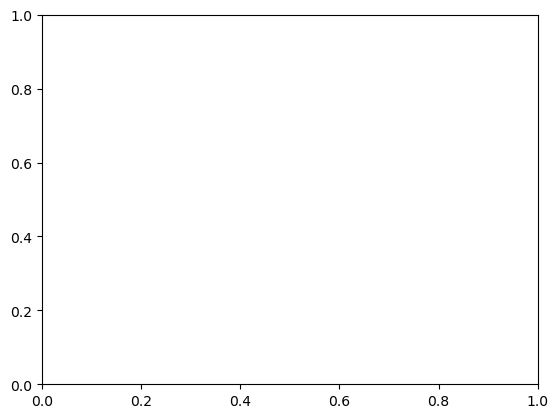

In [10]:
import matplotlib.pyplot as plt

plt.hist([1, 2, 3], bins="5")

## Catching exceptions

An exception can be caught in a `try..except` block. This works as follows:
- if an exception is raised in the `try` block, the next `except` is invoked
- it is tested whether the raised exception is of type subclass of the exception type specified to be caught. For example, `except TypeError` checks if the raised error is of type `TypeError` or a subclass of it.
- if that is not the case, it goes to the next `except` statement (yes, there can be multiple)
- ... more below

In [ ]:
try:
    raise NegativeValueError("Negative value encountered")
except ValueError as error:
    print(f"Caught {error}")

By using the `as` keyword, the error that is raised is assigned to a variable. We can inspect the error now if we want or, as above, just print it.

If no error is specified, _any_ error is caught (this should NOT be used, except for special cases

In [ ]:
try:
    raise TypeError
# Anti-pattern, do NOT use in general!
except:  # any exception if not specified
    pass

In [ ]:
try:
    raise TypeError("Type was wrong, unfortunately")
except TypeError as error:  # any exception
    print(f'caught TypeError: {error}')
    raise
except ValueError as error:
    print(f'caugth ValueError: {error}')

To continue from above: after the last `except`, an `else` statement is looked for. The `else` is executed if _no_ exception was raised.

In [ ]:
try:
    print('no error raised')
#     raise TypeError("Type was wrong, unfortunately")
except TypeError as error:  # any exception
    print(f'caught Type {error}')
except ValueError as error:
    print(f'caugth Value: {error}')
else:
    print("No error")

print("Executed after block")

...and finally, after the else, a `finally` block is looked for. This is *guaranteed* to be executed! Whether an exception is raised, whether it is caught or not, whether there is an `else` or not, the `finally` is _always_ executed.

Therefore it is suitable for any cleanup code such as closing files, removing temporary files and more.

In [ ]:
try:
#     pass
#     raise TypeError("Type was wrong, unfortunately")
    raise RuntimeError("Type was wrong, unfortunately")
except TypeError as error:  # any exception
    print(f'caught Type {error}')
except ValueError as error:
    print(f'caugth Value: {error}')
else:
    print("No error")
finally:  # POWERFUL! Guarantied to be executed
    print('Finally run')
print("Executed when passed")

Note that in the above example, the error was _not_ caught! All the other statements could also be omitted and only a `try...finally` block can be created.

In [ ]:
try:
    raise ValueError
finally:
    print('raised')

### pitfall "guaranteed execution"

As the `finally` is guaranteed to be executed, this can have an odd effect: possible return statements can be ignored _before the finally_ **IF** the `finally` also has a return statement. The logic says here that the `finally` return _must_ be executed, as it is guaranteed to be executed.

In [ ]:
def func(x):
    try:
        if x == 5:
            raise RuntimeError('called inside func')
    except RuntimeError as error:
        return error
    else:
        print('else before 42')
        return 42
        print('after else 42')
    finally:
        print("cleaned up")
        return 11

In [ ]:
func(6)

## Exceptions as control-flow

We are used to control-flow elements such as `if...elif...else` blocks. However, exceptions _can_ also be used for this. They do not replace other ways of control-flow, however there are sometimes situations in which they provide a golden solution to steer the execution.

As an example, consider an `add` function that _sometimes_ can add three elements - which is, for the sake of a good example, favorable as more performant (real world cases of this exist in larger scale, but too complicated to explain here) - and sometimes not. Also assume that the `add` function is called again maybe inside.
A solution is to execute `add` with three elements. If an error is raised, we catch it (the specific one), and run the function again with two arguments and add the third argument by calling `add` again.

Note that this also solves the problem if `add` is called deeper nested again: we don't care _where_ it is called, we just try again with only two numbers. The advantage is that we don't need to check the output of the function; this will always be a number (and not a `None` or something like this).

In [ ]:
def add(a, b, c=None):
    if c is not None:
        raise MyError
    return a + b

In [ ]:
add(1, 2, 3)

In [ ]:
try:
    result = add(1, 2, 3)
except MyError as error:
    result = add(add(1, 2), 3)
result

## Reraising exceptions

An exception can be caught and re-raised. This can be useful if we want to catch an exception, do something and then let the exception propagate further up the stack.

Using `raise` without an argument re-raises the last exception.

Using `raise` with an argument raises a new exception, but with the same stack trace from before. To remove the original stack trace, use `raise from None`.

In [11]:
# "passing through" an error
try:
    raise ValueError("Error")
except ValueError as error:
    print(f"Caught {error}")
    raise

Caught Error


ValueError: Error

In [16]:
# raising a new error
try:
    raise ValueError("Error")
except ValueError as error:
    print(f"Caught {error}")
    raise TypeError("New error")

Caught Error


TypeError: New error

### Remove stacktrace

To remove the stack trace, use `raise from None`.

In [15]:
try:
    raise ValueError("Error")
except ValueError as error:
    print(f"Caught {error}")
    raise TypeError("New error") from None

Caught Error


TypeError: New error

We see a "chained" exception: the first error is caught, then a new error is raised. The stack trace is preserved, which can be very helpful in debugging. It says `During handling of the above exception, another exception occurred:` and then the new exception is printed.

To be more explicit about this, we can use `from` to indicate that the new exception is caused by the old one. This can be useful with nested exceptions.

In [18]:
try:
    raise ValueError("Invalid value")  # try something that will raise an error
except ValueError as error:
    print(f"Caught {error}")
    try:
        raise TypeError("Tried to convert, doesn't work")
    except TypeError as new_error:
        print(f"Caught {new_error}")
        raise RuntimeError("You may forgot to call 'update' first") from error
    print(f"Caught {error}")
    raise TypeError("New error") from error

Caught Invalid value
Caught Tried to convert, doesn't work


RuntimeError: You may forgot to call 'update' first